# Data Processing & Preparation for the RNN

Importing libraries

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.utils import resample
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc



In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
df=pd.read_csv('/content/gdrive/MyDrive/03-CHL5230-F23/mhealth.csv')


In [7]:
df.shape

(999999, 14)

Dropping activity =0 and reassigning indexes

In [16]:
df1 = df.drop(df[df.Activity == 0].index)
df1['Activity']= df1['Activity'] - 1

In [8]:
df1.shape

(279053, 14)

In [16]:
df1.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
6656,2.6493,-9.4517,0.37683,-0.20965,-0.88931,-0.50884,-2.8439,-9.0618,1.8177,-0.058824,-0.93429,-0.34483,0,subject1
6657,2.4157,-9.5306,0.40179,-0.20965,-0.88931,-0.50884,-2.9935,-9.2048,1.5189,-0.058824,-0.93429,-0.34483,0,subject1
6658,2.3865,-9.5991,0.48141,-0.20037,-0.86867,-0.50688,-2.8846,-9.1945,1.5507,-0.058824,-0.93429,-0.34483,0,subject1
6659,2.3758,-9.5997,0.42919,-0.20037,-0.86867,-0.50688,-2.9245,-9.1746,1.5413,-0.078431,-0.93429,-0.34052,0,subject1
6660,2.3239,-9.5406,0.40038,-0.20037,-0.86867,-0.50688,-2.8963,-9.2039,1.6127,-0.078431,-0.93429,-0.34052,0,subject1


In [10]:
df1.describe()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity
count,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000
mean,1.798474,-9.068946,-0.685158,0.069498,-0.550920,-0.093453,-3.308450,-5.864111,2.450921,-0.216789,-0.398342,0.374262,5.099841
std,4.129356,5.146080,6.413988,0.469530,0.434784,0.555759,5.898885,6.579659,4.267147,0.540130,0.556498,0.519582,3.323515
min,-22.146000,-19.619000,-19.373000,-1.779200,-2.602300,-2.554000,-22.345000,-18.972000,-18.238000,-1.170600,-2.205300,-1.114200,0.000000
25%,0.155090,-10.040000,-3.370600,-0.389610,-0.804880,-0.544200,-4.882000,-9.573100,0.378110,-0.662750,-0.829570,-0.051724,2.000000
50%,1.417300,-9.589600,0.335820,0.148420,-0.682930,-0.041257,-2.335900,-7.797600,1.969300,-0.303920,-0.597540,0.441810,5.000000
75%,2.904700,-7.525000,1.808000,0.465680,-0.497190,0.359530,-0.420180,-2.412500,5.223500,0.180390,-0.024641,0.840520,8.000000
max,20.024000,21.161000,25.015000,1.710600,1.752300,1.581500,19.801000,21.965000,25.741000,1.321600,1.121100,1.528000,11.000000


In [11]:
df1.isna().sum()  # no missing values

alx         0
aly         0
alz         0
glx         0
gly         0
glz         0
arx         0
ary         0
arz         0
grx         0
gry         0
grz         0
Activity    0
subject     0
dtype: int64

In [12]:
df1.shape

(279053, 14)

In [13]:
df1['subject'].nunique()   # only 9 subjects, many repeated observations

9

In [14]:
df.groupby('subject').size()  # number of repeated measurements per subject

subject
subject1    161280
subject2    130561
subject3    122112
subject4    116736
subject5    119808
subject6     98304
subject7    104448
subject8    129024
subject9     17726
dtype: int64

In [15]:
df1['Activity'].unique()

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11,  4])

Train test splitting needs to maintain the grouped structure in time series data

Grouping Data

**Without activity = 0**

In [18]:
grouped = (df1.groupby('subject').apply(len) >= 2)
grouped_df = df1[df1['subject'].isin(grouped[grouped].index)]
df2=grouped_df
df2.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
6656,2.6493,-9.4517,0.37683,-0.20965,-0.88931,-0.50884,-2.8439,-9.0618,1.8177,-0.058824,-0.93429,-0.34483,0,subject1
6657,2.4157,-9.5306,0.40179,-0.20965,-0.88931,-0.50884,-2.9935,-9.2048,1.5189,-0.058824,-0.93429,-0.34483,0,subject1
6658,2.3865,-9.5991,0.48141,-0.20037,-0.86867,-0.50688,-2.8846,-9.1945,1.5507,-0.058824,-0.93429,-0.34483,0,subject1
6659,2.3758,-9.5997,0.42919,-0.20037,-0.86867,-0.50688,-2.9245,-9.1746,1.5413,-0.078431,-0.93429,-0.34052,0,subject1
6660,2.3239,-9.5406,0.40038,-0.20037,-0.86867,-0.50688,-2.8963,-9.2039,1.6127,-0.078431,-0.93429,-0.34052,0,subject1


In [42]:
df2.describe()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity
count,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000,279053.000000
mean,1.798474,-9.068946,-0.685158,0.069498,-0.550920,-0.093453,-3.308450,-5.864111,2.450921,-0.216789,-0.398342,0.374262,5.099841
std,4.129356,5.146080,6.413988,0.469530,0.434784,0.555759,5.898885,6.579659,4.267147,0.540130,0.556498,0.519582,3.323515
min,-22.146000,-19.619000,-19.373000,-1.779200,-2.602300,-2.554000,-22.345000,-18.972000,-18.238000,-1.170600,-2.205300,-1.114200,0.000000
25%,0.155090,-10.040000,-3.370600,-0.389610,-0.804880,-0.544200,-4.882000,-9.573100,0.378110,-0.662750,-0.829570,-0.051724,2.000000
50%,1.417300,-9.589600,0.335820,0.148420,-0.682930,-0.041257,-2.335900,-7.797600,1.969300,-0.303920,-0.597540,0.441810,5.000000
75%,2.904700,-7.525000,1.808000,0.465680,-0.497190,0.359530,-0.420180,-2.412500,5.223500,0.180390,-0.024641,0.840520,8.000000
max,20.024000,21.161000,25.015000,1.710600,1.752300,1.581500,19.801000,21.965000,25.741000,1.321600,1.121100,1.528000,11.000000


**With all activities**

In [19]:
grouped_allact = (df.groupby('subject').apply(len) >= 2)
grouped_df_allact = df[df['subject'].isin(grouped_allact[grouped_allact].index)]
df2_all=grouped_df_allact
df2_all.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


In [44]:
df2_all.describe()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity
count,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
mean,1.473954,-9.618162,-0.944714,-0.023928,-0.616830,-0.131466,-3.578801,-5.72591,2.645165,-0.293943,-0.450610,0.283440,1.702181
std,3.751845,4.076683,5.333969,0.495758,0.354135,0.547774,4.770602,5.70559,3.897641,0.528506,0.564118,0.558707,3.250841
min,-22.146000,-19.619000,-19.373000,-2.146600,-7.789900,-2.567800,-22.361000,-18.97200,-18.239000,-8.339200,-3.570800,-2.689700,0.000000
25%,0.115100,-10.116000,-2.662400,-0.454550,-0.816140,-0.561890,-5.984100,-9.36790,0.406120,-0.711760,-0.882960,-0.211210,0.000000
50%,1.336800,-9.644800,-0.016372,-0.070501,-0.703560,-0.137520,-2.859700,-7.35990,2.231200,-0.372550,-0.622180,0.325430,0.000000
75%,2.586900,-9.034300,1.371500,0.426720,-0.542210,0.345780,-1.021200,-2.45280,5.201200,0.049020,-0.080082,0.786640,2.000000
max,20.054000,21.161000,25.015000,60.484000,2.011300,2.770100,19.864000,22.19100,25.741000,3.319600,1.556500,2.750000,12.000000


# Exploratory Data Analysis

**Looking at class balance**

In [22]:
df2['Activity'].unique()

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11,  4])

In [23]:
class_distribution = df2.groupby('subject')['Activity'].value_counts()
class_distribution

subject   Activity
subject1  7           3379
          0           3072
          1           3072
          2           3072
          3           3072
                      ... 
subject8  7           2560
          5           2151
          11          1024
subject9  0           3072
          1            830
Name: Activity, Length: 98, dtype: int64

In [24]:
df2[df2['subject'] == "subject8"]['Activity'].unique()    # unique activities for subject 8

array([ 0,  2,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [25]:
df2[df2['subject'] == "subject9"]['Activity'].unique()

array([0, 1])

In [26]:
df2['subject'].unique().tolist()    # the subjects in our training data

['subject1',
 'subject2',
 'subject3',
 'subject4',
 'subject5',
 'subject6',
 'subject7',
 'subject8',
 'subject9']

with activity=0

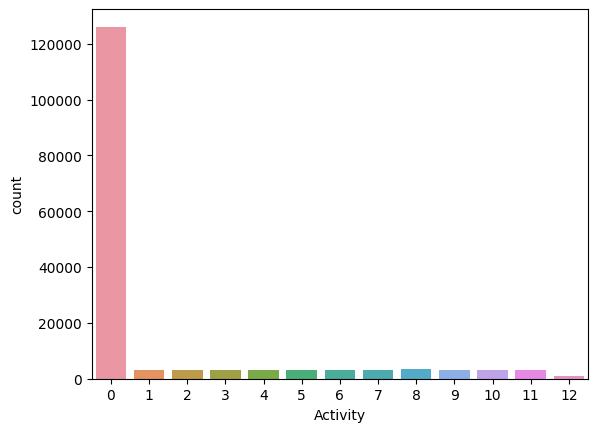

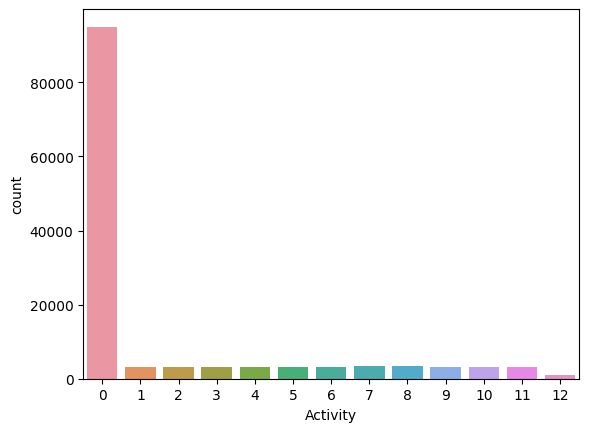

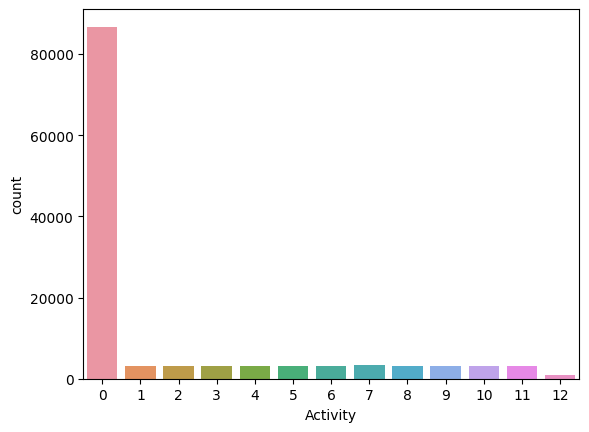

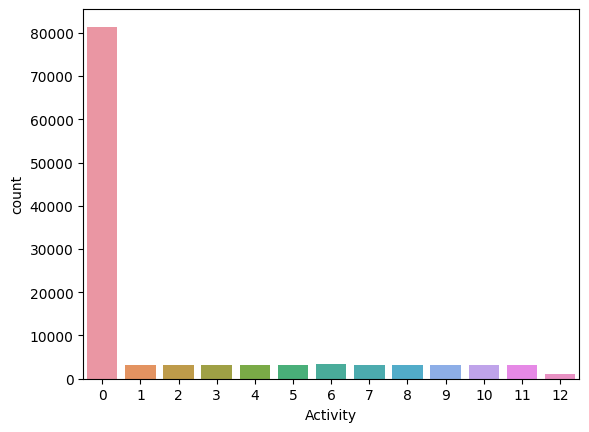

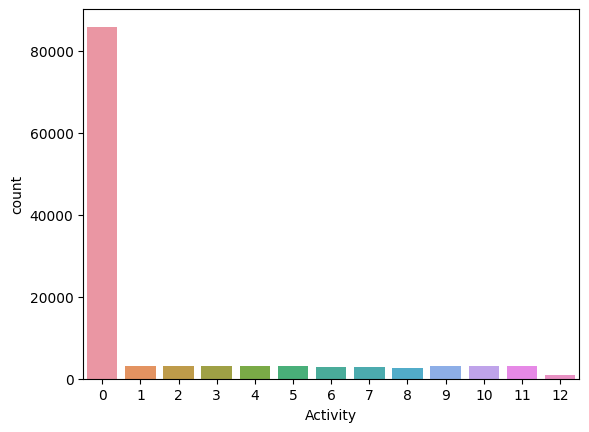

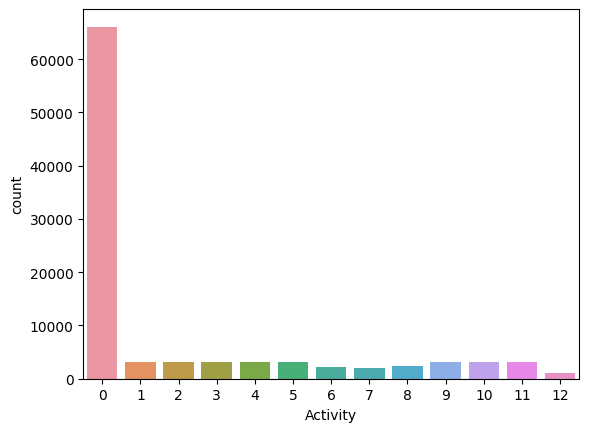

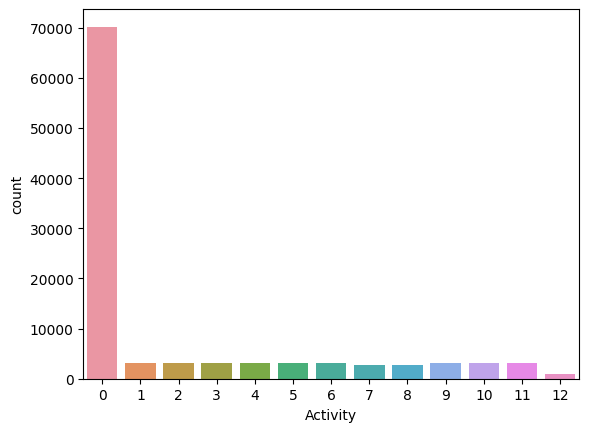

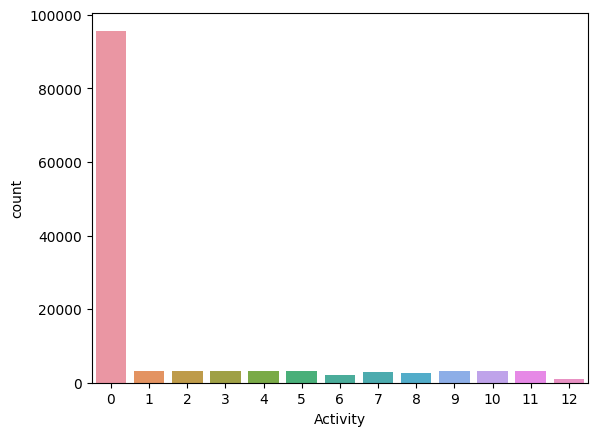

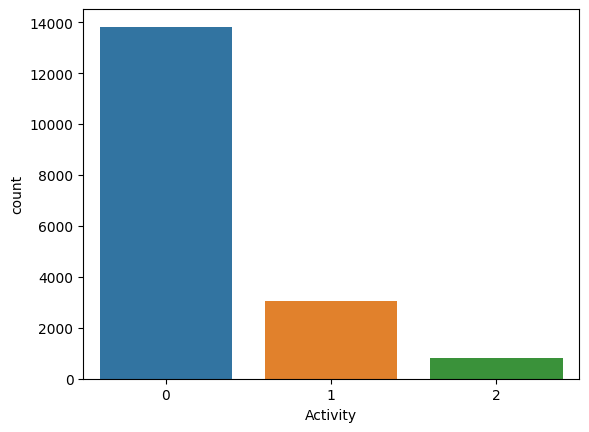

In [27]:
for s in df2_all['subject'].unique().tolist():
  d = df2_all[df2_all['subject'] == s]
  plt.figure()
  sns.countplot(d, x="Activity")

without activity =0

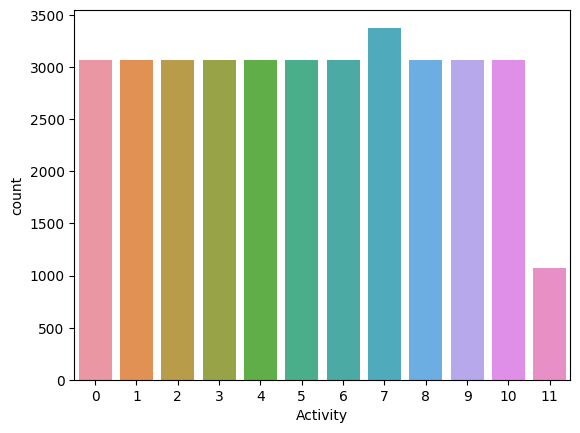

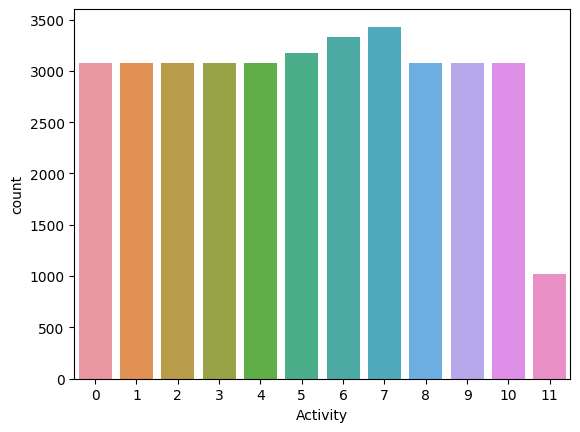

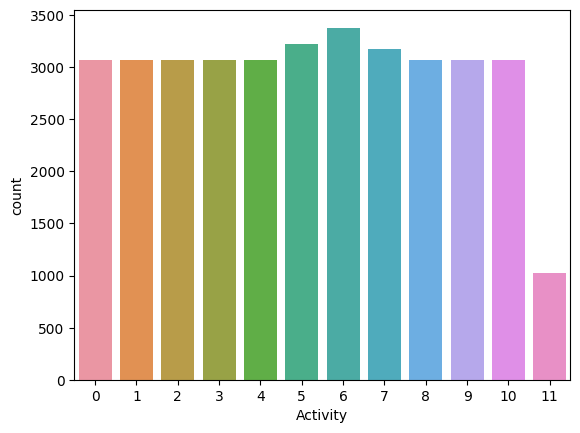

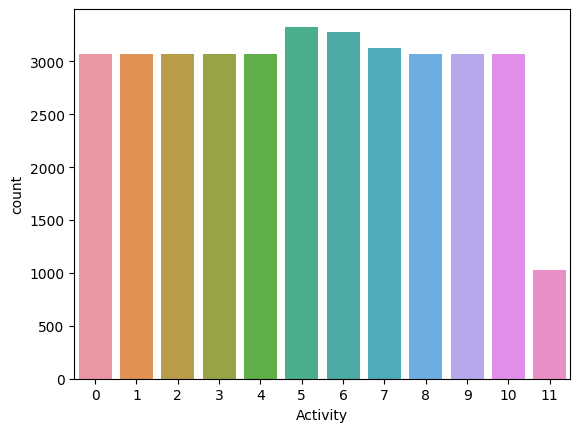

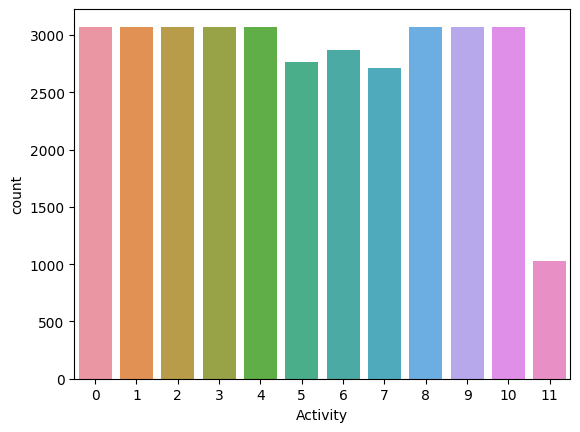

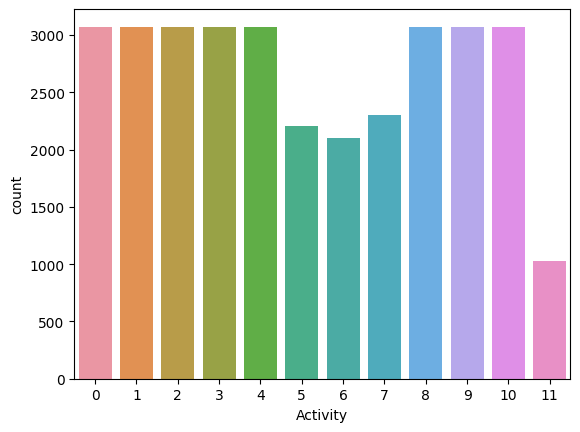

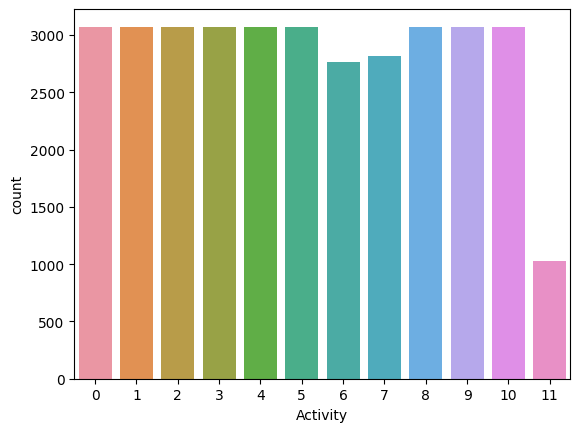

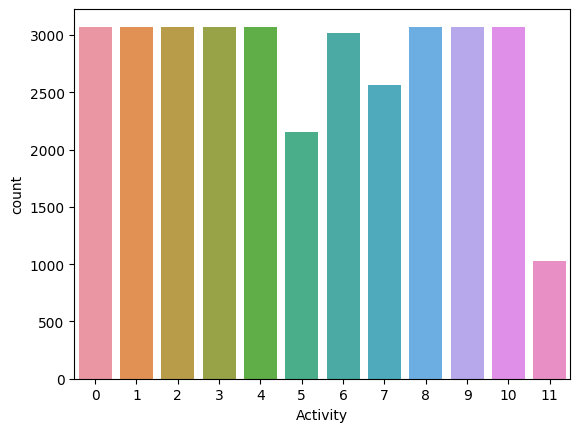

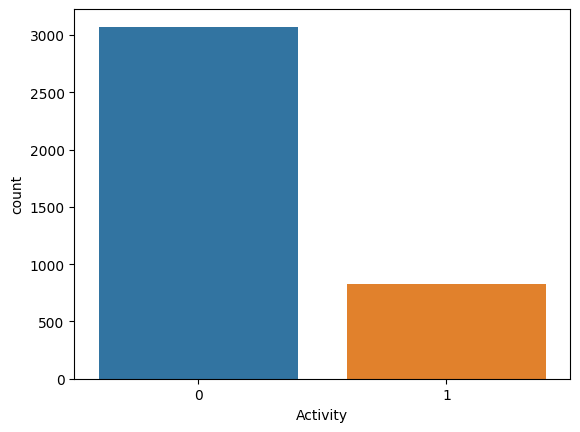

In [28]:
for s in df2['subject'].unique().tolist():
  d = df2[df2['subject'] == s]
  plt.figure()
  sns.countplot(d, x="Activity")

From above we see that most of the time subjects are not doing anything (activity = 0)

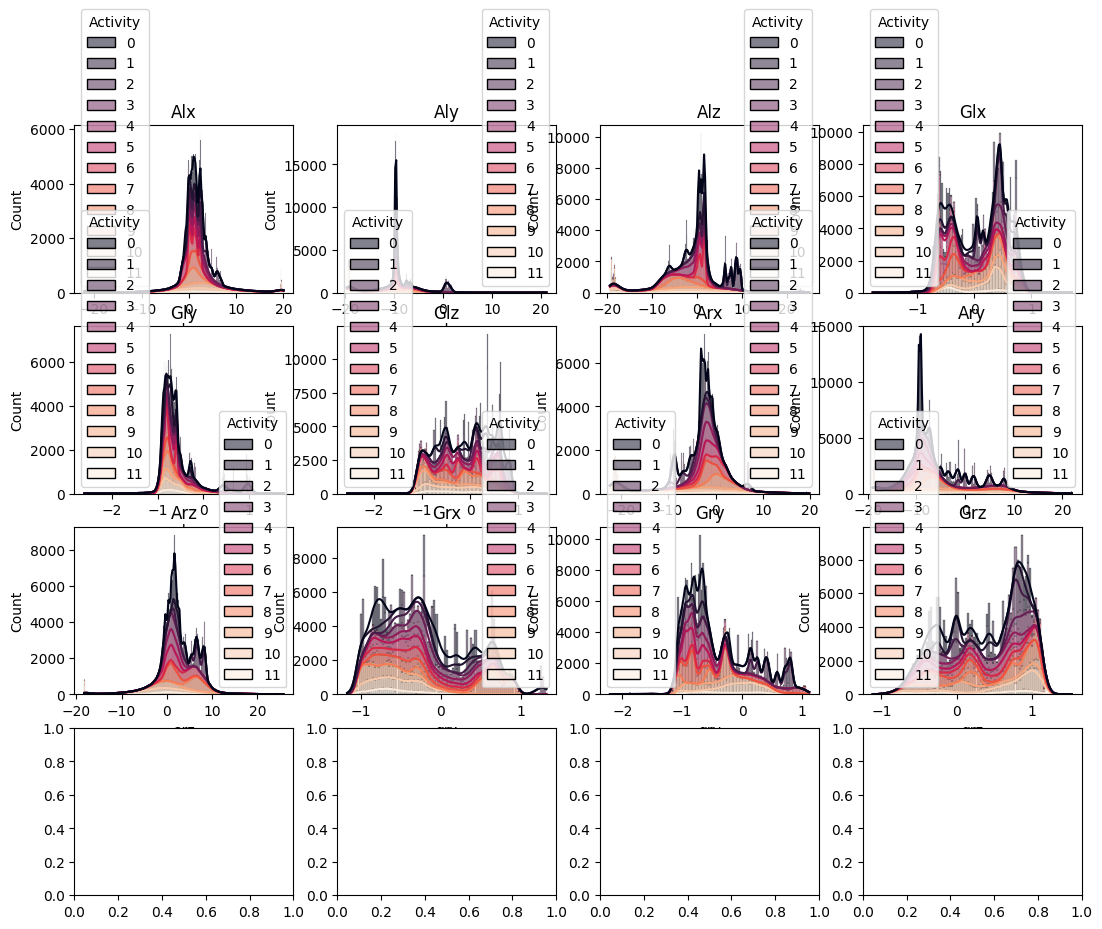

In [ ]:

# Update the list of meaningful columns based on the available columns in the dataset
selected_columns_for_analysis = ['alx', 'aly', 'alz', 'glx', 'gly', 'glz', 'arx', 'ary', 'arz', 'grx', 'gry', 'grz']

# Create a grid of subplots with 3 rows and 4 columns
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(13, 10))

# Loop over each selected feature to create a subplot for each
for i, column in enumerate(selected_columns_for_analysis):
    # Calculate the position for the subplot; x is the row index and y is the column index
    x = i // 4
    y = i % 4

    # Plot a histogram of the feature split by the '' class
    sns.histplot(df2, x=column, hue='Activity', kde=True, palette='rocket', ax=axs[x][y],
                 multiple='stack')
    axs[x][y].set_title(column.replace('_', ' ').title())

# Adjust the layout and display all the subplots
plt.show()

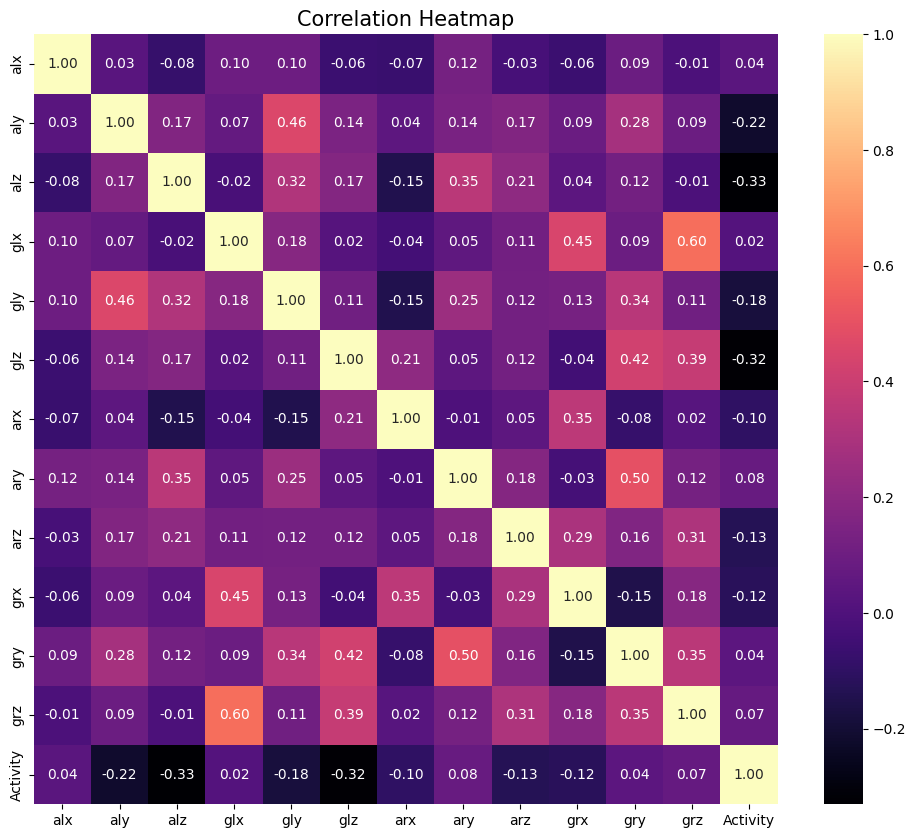

In [ ]:
import numpy as np

# For the correlation heatmap, we'll use only numerical columns.
# We'll update the list of numerical features to exclude columns with '_id' in their names.
numerical_features = [
    col for col in df2.select_dtypes(include=[np.number]).columns
    if not col.endswith('_id')
]

# Recalculate the correlation matrix without the '_id' columns
correlation_matrix = df2[numerical_features].corr()

# Plot the updated correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='magma')
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

# Splitting Data







In [ ]:
df2.dtypes


alx         float64
aly         float64
alz         float64
glx         float64
gly         float64
glz         float64
arx         float64
ary         float64
arz         float64
grx         float64
gry         float64
grz         float64
Activity      int64
subject      object
dtype: object

Encoding not needed since all features are numeric

Building the model

Without activity =0

In [20]:
#splitting data
grouped = df2.groupby('subject')
grouped_dfs = [group for _, group in grouped]

train_groups, test_groups = train_test_split(grouped_dfs, test_size=0.2, random_state=42)

train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)


#normalization
cols = train_df.columns.tolist()
cols.remove('subject')   # subject id
cols.remove('Activity')  # response

scaler = StandardScaler()
train_df[cols] = scaler.fit_transform(train_df[cols])
test_df[cols] = scaler.transform(test_df[cols])

train_df.head()

##### create sequence
sensor_columns = ['alx', 'aly', 'alz', 'glx', 'gly', 'glz', 'arx', 'ary', 'arz', 'grx', 'gry', 'grz']
train_data_normalized = train_df
test_data_normalized = test_df

def create_sequences(df2, sequence_length=100):
    sequences = []
    output = []
    for i in range(0, len(df2) - sequence_length + 1, sequence_length):
        sequence = df2[i:i + sequence_length]
        # Assuming 'activity' is target variable and is the same for entire sequence
        label = sequence['Activity'].iloc[0]
        sequences.append(sequence[sensor_columns].values)
        output.append(label)

    return np.array(sequences), np.array(output)

# Creating sequences for training and test data
X_train, y_train = create_sequences(train_data_normalized, sequence_length=100)
X_test, y_test = create_sequences(test_data_normalized, sequence_length=100)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 256  # Number of hidden units in RNN
num_classes = 12
epochs = 30
learning_rate = 0.001
batch_size = 512
landa = 0.001  # Regularization term (lambda)

# Data preparation
train_dataset = TensorDataset(t.tensor(X_train, dtype=t.float32), t.tensor(y_train, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(X_test, dtype=t.float32), t.tensor(y_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN layers and additional fully connected layer
rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)  # Add dropout between RNN layers
rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
dropout2 = nn.Dropout(0.5)  # Add dropout between RNN layers
fc_layer1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
fc_layer2 = nn.Linear(hidden_size, num_classes)  # Final output layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Activation function
relu = nn.ReLU()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)
#optimizer = Adam(list(rnn_layer1.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracy_list = []
test_accuracy_list = []
train_loss_list = []

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        out, _ = rnn_layer2(out)
        out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]  # Get the last output of the sequence
        out = relu(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        # Regularization
        l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        loss = loss_fn(out, Y) + landa * l2_term
        #loss = loss_fn(out, Y)

        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation on training and test data
    rnn_layer1.eval()
    rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out, _ = rnn_layer2(out)
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # test data
        test_correct, test_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out, _ = rnn_layer2(out)
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            test_total += Y.size(0)
            test_correct += (predicted == Y).sum().item()
        test_accuracy = 100 * test_correct / test_total

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, test Accuracy: {test_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    rnn_layer1.train()
    rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()


Epoch 0/30 ---> Train Accuracy: 17.277486910994764%, test Accuracy: 13.081395348837209%
Epoch 1/30 ---> Train Accuracy: 23.750594954783438%, test Accuracy: 27.325581395348838%
Epoch 2/30 ---> Train Accuracy: 32.175154688243694%, test Accuracy: 30.813953488372093%
Epoch 3/30 ---> Train Accuracy: 38.83864826273203%, test Accuracy: 29.069767441860463%
Epoch 4/30 ---> Train Accuracy: 38.69585911470728%, test Accuracy: 33.72093023255814%
Epoch 5/30 ---> Train Accuracy: 44.88338886244645%, test Accuracy: 33.28488372093023%
Epoch 6/30 ---> Train Accuracy: 48.02475011899096%, test Accuracy: 36.33720930232558%
Epoch 7/30 ---> Train Accuracy: 56.87767729652546%, test Accuracy: 31.83139534883721%
Epoch 8/30 ---> Train Accuracy: 55.164207520228466%, test Accuracy: 43.16860465116279%
Epoch 9/30 ---> Train Accuracy: 64.49309852451213%, test Accuracy: 41.86046511627907%
Epoch 10/30 ---> Train Accuracy: 66.53974297953356%, test Accuracy: 43.75%
Epoch 11/30 ---> Train Accuracy: 70.29985721085197%, test

In [21]:
# Assuming train_accuracy_list and test_accuracy_list are your lists
train_avg_accuracy = sum(train_accuracy_list) / len(train_accuracy_list)
test_avg_accuracy = sum(test_accuracy_list) / len(test_accuracy_list)

print(f"Average Training Accuracy: {train_avg_accuracy}")
print(f"Average Test Accuracy: {test_avg_accuracy}")


Average Training Accuracy: 60.10471204188481
Average Test Accuracy: 41.681201550387605


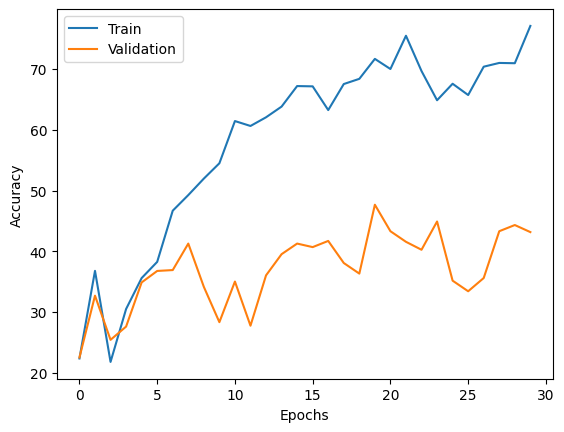

In [10]:
# Plot training and test accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(test_accuracy_list))], test_accuracy_list, label="test")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

With activity =0

In [22]:
#splitting data
grouped_all = df2_all.groupby('subject')
grouped_dfs_all = [group for _, group in grouped_all]

train_groups, test_groups = train_test_split(grouped_dfs_all, test_size=0.2, random_state=42)

train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)


#normalization
cols = train_df.columns.tolist()
cols.remove('subject')   # subject id
cols.remove('Activity')  # response

scaler = StandardScaler()
train_df[cols] = scaler.fit_transform(train_df[cols])
test_df[cols] = scaler.transform(test_df[cols])

train_df.head()

##### create sequence
sensor_columns = ['alx', 'aly', 'alz', 'glx', 'gly', 'glz', 'arx', 'ary', 'arz', 'grx', 'gry', 'grz']
train_data_normalized = train_df
test_data_normalized = test_df

def create_sequences(df2_all, sequence_length=100):
    sequences = []
    output = []
    for i in range(0, len(df2_all) - sequence_length + 1, sequence_length):
        sequence = df2_all[i:i + sequence_length]
        # Assuming 'activity' is target variable and is the same for entire sequence
        label = sequence['Activity'].iloc[0]
        sequences.append(sequence[sensor_columns].values)
        output.append(label)

    return np.array(sequences), np.array(output)

# Creating sequences for training and test data
X_train, y_train = create_sequences(train_data_normalized, sequence_length=100)
X_test, y_test = create_sequences(test_data_normalized, sequence_length=100)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 256  # Number of hidden units in RNN
num_classes = 13
epochs = 30
learning_rate = 0.001
batch_size = 512
landa = 0.001  # Regularization term (lambda)

# Data preparation
train_dataset = TensorDataset(t.tensor(X_train, dtype=t.float32), t.tensor(y_train, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(X_test, dtype=t.float32), t.tensor(y_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN layers and additional fully connected layer
rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)  # Add dropout between RNN layers
rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
dropout2 = nn.Dropout(0.5)  # Add dropout between RNN layers
fc_layer1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
fc_layer2 = nn.Linear(hidden_size, num_classes)  # Final output layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Activation function
relu = nn.ReLU()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)
#optimizer = Adam(list(rnn_layer1.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracy_list = []
test_accuracy_list = []
train_loss_list = []

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        out, _ = rnn_layer2(out)
        out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]  # Get the last output of the sequence
        out = relu(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)

        # Regularization
        l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        loss = loss_fn(out, Y) + landa * l2_term
        #loss = loss_fn(out, Y)

        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation on training and test data
    rnn_layer1.eval()
    rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out, _ = rnn_layer2(out)
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # test data
        test_correct, test_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out, _ = rnn_layer2(out)
            out = out[:, -1, :]
            out = relu(fc_layer1(out))
            out = fc_layer2(out)
            _, predicted = t.max(out.data, 1)
            test_total += Y.size(0)
            test_correct += (predicted == Y).sum().item()
        test_accuracy = 100 * test_correct / test_total

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, test Accuracy: {test_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    rnn_layer1.train()
    rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()



Epoch 0/30 ---> Train Accuracy: 72.73095623987034%, test Accuracy: 73.79576107899807%
Epoch 1/30 ---> Train Accuracy: 72.94705564559698%, test Accuracy: 73.68015414258188%
Epoch 2/30 ---> Train Accuracy: 72.67693138843867%, test Accuracy: 74.25818882466281%
Epoch 3/30 ---> Train Accuracy: 72.85251215559157%, test Accuracy: 74.373795761079%
Epoch 4/30 ---> Train Accuracy: 72.89303079416531%, test Accuracy: 74.45086705202313%
Epoch 5/30 ---> Train Accuracy: 72.92004321988115%, test Accuracy: 74.45086705202313%
Epoch 6/30 ---> Train Accuracy: 72.87952458130741%, test Accuracy: 74.29672447013488%
Epoch 7/30 ---> Train Accuracy: 72.9740680713128%, test Accuracy: 73.83429672447014%
Epoch 8/30 ---> Train Accuracy: 73.892490545651%, test Accuracy: 74.18111753371869%
Epoch 9/30 ---> Train Accuracy: 73.19016747703944%, test Accuracy: 72.60115606936417%
Epoch 10/30 ---> Train Accuracy: 69.01674770394382%, test Accuracy: 62.19653179190752%
Epoch 11/30 ---> Train Accuracy: 73.13614262560777%, test 

In [24]:
# Assuming train_accuracy_list and test_accuracy_list are your lists
train_avg_accuracy = sum(train_accuracy_list) / len(train_accuracy_list)
test_avg_accuracy = sum(test_accuracy_list) / len(test_accuracy_list)

print(f"Average Training Accuracy: {train_avg_accuracy}")
print(f"Average Test Accuracy: {test_avg_accuracy}")


Average Training Accuracy: 74.32378894291377
Average Test Accuracy: 74.60115606936417


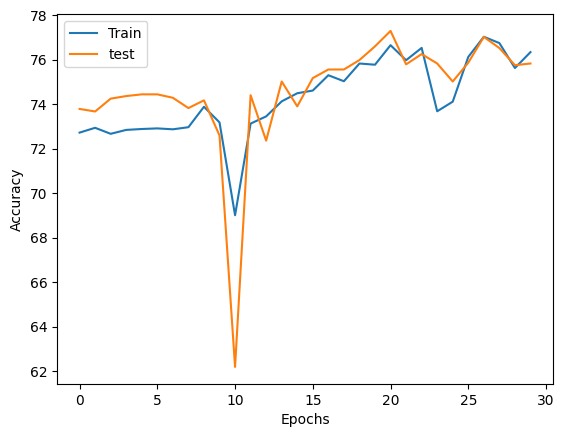

In [25]:
# Plot training and test accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(test_accuracy_list))], test_accuracy_list, label="test")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()